#### SHAP Parameter Importance Ranking  
by: Angel Moreno

Below I am defining the predictor variables and target variable for this analysis.

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle
import warnings
import logging
# from contextlib import redirect_stdout
# import io

# from catboost import CatBoostRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
# import shap

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import root_mean_squared_error
from kneed import KneeLocator

import torch
import optuna 
from optuna.samplers import TPESampler

In [85]:
########### RUN ME ###########

# master data here
df_2017 = pd.read_csv("../finished_csvs/master_2017.csv")
df_2018 = pd.read_csv("../finished_csvs/master_2018.csv")
df_2019 = pd.read_csv("../finished_csvs/master_2019.csv")
df_2020 = pd.read_csv("../finished_csvs/master_2020.csv")
df_2021 = pd.read_csv("../finished_csvs/master_2021.csv")
df_2022 = pd.read_csv("../finished_csvs/master_2022.csv")
df_2023 = pd.read_csv("../finished_csvs/master_2023.csv")
df_2024 = pd.read_csv("../finished_csvs/master_2024.csv")

dfs = [df_2017, df_2018, df_2019, df_2020,
       df_2021, df_2022, df_2023, df_2024]

print(df_2017.columns)
print(f"This shape should be uniform across all dfs: {df_2017.shape}")

# these will be the same predictor variables for all 8 csv files (2017-2024)
# df_2017.columns[2:66]
predictors = ['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06',
       'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16',
       'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26',
       'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36',
       'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46',
       'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56',
       'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63']
# likewise, this will be the same target variable ('Cases_20XX_normalized')
# always at the end of the dfs
example_Y = df_2017.columns[-1]

print(predictors)
print('\n')
print(example_Y)

Index(['County', 'GEOID', 'A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06',
       'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16',
       'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26',
       'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36',
       'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46',
       'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56',
       'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'Cases_2017',
       '2017_population', 'Cases_2017_normalized'],
      dtype='object')
This shape should be uniform across all dfs: (102, 69)
['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48

#### CatBoost Model Performance

CatBoost is a gradient boosting based model that is excellent when there is a lot of categorical data. 

In [5]:
# # dfs_testing = [df_2017]
# avg_rmse_scores_2017_2024 = []

# # keep 5 for now but maybe increase if it runs somewhat fast
# kfold = KFold(n_splits=5, shuffle=True, random_state = 27)

# count = 0
# year = 2017

# for df in dfs:
#   count += 1
#   print(f"processing {count}/8")
#   # only need to redefine Y var
#   X = df[predictors]
#   Y = df[df.columns[-1]]
#   # https://catboost.ai/docs/en/concepts/parameter-tuning
#   catboost = CatBoostRegressor(
#     # default is 1000, but I will use 2000 since this is a smaller dataset
#     iterations=2000,
#     # depth 6 to 10 recommended
#     depth=8,
#     loss_function='RMSE',
#     verbose=False,
#     random_seed = 27
#   )

#   score = cross_val_score(catboost, X, Y, cv=kfold, scoring="neg_root_mean_squared_error")
#   pos_score = -score
#   avg_rmse_scores_2017_2024.append({
#     "year":year,
#     "rmse":pos_score.mean()
#   })

#   year += 1
# # end of model validation

In [ ]:
avg_rmse_scores_2017_2024

[{'year': 2017, 'rmse': np.float64(1.252681326251258)},
 {'year': 2018, 'rmse': np.float64(2.0558699845501422)},
 {'year': 2019, 'rmse': np.float64(1.295106391978416)},
 {'year': 2020, 'rmse': np.float64(0.2698741270348198)},
 {'year': 2021, 'rmse': np.float64(0.3082954710613737)},
 {'year': 2022, 'rmse': np.float64(0.36875699042322657)},
 {'year': 2023, 'rmse': np.float64(1.1491637791879044)},
 {'year': 2024, 'rmse': np.float64(0.33702369708109414)}]

In [ ]:
# output:
# [{'year': 2017, 'rmse': np.float64(1.252681326251258)},
#  {'year': 2018, 'rmse': np.float64(2.0558699845501422)},
#  {'year': 2019, 'rmse': np.float64(1.295106391978416)},
#  {'year': 2020, 'rmse': np.float64(0.2698741270348198)},
#  {'year': 2021, 'rmse': np.float64(0.3082954710613737)},
#  {'year': 2022, 'rmse': np.float64(0.36875699042322657)},
#  {'year': 2023, 'rmse': np.float64(1.1491637791879044)},
#  {'year': 2024, 'rmse': np.float64(0.33702369708109414)}]

#### TabNet Model Performance

TabNet is a deep learning model created for tabular data.

In [ ]:
# def tabnet_cv_rmse(X, y, k=5):
#   '''
#   Ignore early stoppage and record avg rmse for ONE day only. 
#   '''
#   kfold = KFold(n_splits=k, shuffle=True, random_state=27)
#   fold_rmses = []
#   warnings.filterwarnings("ignore")

#   # since tabnet does not support sklearn cross validation
#   # we will manually compute rmse for each fold
#   for train_idx, test_idx in kfold.split(X):
#     X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]

#     model = TabNetRegressor(
#       n_d=8, n_a=8, n_steps=3,
#       gamma=1.5, lambda_sparse=1e-4,
#       seed=27, verbose=0
#     )

#     # --- suppress TabNet's early stopping printouts ---
#     # this is so I can actually record the best RMSE for each year and get the average
#     f = io.StringIO()
#     with redirect_stdout(f):
#       model.fit(
#         X_train.values,
#         y_train.reshape(-1, 1),
#         eval_set=[(X_test.values, y_test.reshape(-1, 1))],
#         eval_metric=['rmse'],
#         max_epochs=200,
#         patience=20,
#         batch_size=64,
#         virtual_batch_size=32)

#     preds = model.predict(X_test.values).reshape(-1)
#     rmse = np.sqrt(mean_squared_error(y_test, preds))
#     fold_rmses.append(rmse)

#   # return avg 5 fold rmse for current year
#   return np.mean(fold_rmses)

In [ ]:
# results = {}
# dfs_testing = [df_2017]

# year = 2017
# for df in dfs:
#   print(f"processing: {year}")
#   X = df[predictors]
#   y = df[df.columns[-1]].values
#   avg_rmse = tabnet_cv_rmse(X, y)
#   results[df.columns[-1]] = avg_rmse
#   year += 1

processing: 2017
processing: 2018
processing: 2019
processing: 2020
processing: 2021
processing: 2022
processing: 2023
processing: 2024


In [ ]:
results

{'Cases_2017_normalized': np.float64(1.0637535650384204),
 'Cases_2018_normalized': np.float64(1.815861333367744),
 'Cases_2019_normalized': np.float64(1.1135452653746047),
 'Cases_2020_normalized': np.float64(0.21372876809420177),
 'Cases_2021_normalized': np.float64(0.29463561869059474),
 'Cases_2022_normalized': np.float64(0.34777232804185193),
 'Cases_2023_normalized': np.float64(1.2375243289851097),
 'Cases_2024_normalized': np.float64(0.3293317663979392)}

Catboost and TabNet final results:

CatBoost 5-fold cross validation mean rmse for each year: 

[{'year': 2017, 'rmse': np.float64(1.252681326251258)},     
 {'year': 2018, 'rmse': np.float64(2.0558699845501422)},    
 {'year': 2019, 'rmse': np.float64(1.295106391978416)},   
 {'year': 2020, 'rmse': np.float64(0.2698741270348198)},    
 {'year': 2021, 'rmse': np.float64(0.3082954710613737)},    
 {'year': 2022, 'rmse': np.float64(0.36875699042322657)},   
 {'year': 2023, 'rmse': np.float64(1.1491637791879044)},    
 {'year': 2024, 'rmse': np.float64(0.33702369708109414)}]   


TabNet 5-fold cross validation mean rmse for each year: 

{'Cases_2017_normalized': np.float64(1.0637535650384204),   
 'Cases_2018_normalized': np.float64(1.815861333367744),    
 'Cases_2019_normalized': np.float64(1.1135452653746047),   
 'Cases_2020_normalized': np.float64(0.21372876809420177),    
 'Cases_2021_normalized': np.float64(0.29463561869059474),    
 'Cases_2022_normalized': np.float64(0.34777232804185193),    
 'Cases_2023_normalized': np.float64(1.2375243289851097),   
 'Cases_2024_normalized': np.float64(0.3293317663979392)}   

So in general, the performance is very similar between the two. CatBoost is better (lower RMSE values for a given year) in some years while TabNet is very close in performance most years. Overall, TabNet seems to be producing the lower RMSE overall. 

#### SHAP-TabNet Ranking for 2017-2024

Now that I have seen and recorded TabNet's performance against CatBoost, I will now produce the SHAP plots for 2017-2024.       
The plots will be beeswarm and  bar plots. 

In [ ]:
df_2017

In [ ]:
year = 2017
dfs_testing = [df_2017,df_2018]
df_save = pd.DataFrame() # empty df for now, will append series

for df in dfs:
    print(f"training TabNet for {year}")
    ##### same as cv section #####
    X = df[predictors]
    Y = df[df.columns[-1]]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=27)

    # https://dreamquark-ai.github.io/tabnet/generated_docs/README.html
    model = TabNetRegressor(
        # hyperparameters

        # default 8, n_d = n_a recommended
        n_d=8, 
        n_a=8, 
        # default = 3, good for smaller datasets
        n_steps=3,
        # feature reuse (1.0 to 2.0)
        gamma=1.5, 
        lambda_sparse=1e-4,
        seed=27, verbose=0
    )

    model.fit(
        X_train.values,
        y_train.values.reshape(-1, 1),
        eval_set=[(X_test.values, y_test.values.reshape(-1, 1))],
        eval_metric=['rmse'],
        # default 200
        max_epochs=200,
        # max num epochs without any change before early stoppage
        patience=20,
        batch_size=64,
        virtual_batch_size=32
    )
    ##### end training #####

    shap_values, masks = model.explain(X_test.values)
    
    # mean abs shap -> avg across all samples in X_test
    mean_abs_shap = pd.Series(np.mean(np.abs(shap_values), axis=0), index=X_test.columns)

    # change 12/1/25 -> normalize on the max and not the sum (for bar plot)
    # normalized values on the max will be used for the heatmap as well (see next section)

    shap_normalized = mean_abs_shap / mean_abs_shap.max()

    df_save[year] = shap_normalized

    # ignoring sorting for now
    # mean_abs_shap = mean_abs_shap.sort_values(ascending=False)

    print(f"Plotting SHAP values for {year}")

    # save path for the plots
    beeswarm_summary_path = "../shap_plots/beeswarm_plots/"
    bar_plots_path = "../shap_plots/bar_plots/"

    os.makedirs(beeswarm_summary_path, exist_ok=True)
    os.makedirs(bar_plots_path, exist_ok=True)

    file_path_beeswarm = os.path.join(beeswarm_summary_path, f'beeswarm_plot_for_{year}.png')
    file_path_bar = os.path.join(bar_plots_path, f'bar_plot_for_{year}.png')

    # first plot -> beeswarm plot for all 64 features 
    # note: beeswarm plots do not need normalization
    plt.title(f'TabNet SHAP Feature Importance - {df.columns[-1].replace("_", " ")}')
    # this uses NOT normalized shap_values.
    shap_exp = shap.Explanation(values = shap_values, data = X_test.values, feature_names = X_test.columns)
    shap.plots.beeswarm(shap_exp, max_display=64, show=False)
    # plt.show()
    fig = plt.gcf()
    plt.savefig(file_path_beeswarm, dpi=300, bbox_inches="tight")
    plt.close(fig)

    # second plot -> bar plot for all 64 features 
    plt.figure(figsize=(10,6))
    shap_normalized.plot(kind='bar')
    plt.title(f'TabNet SHAP Feature Importance - {df.columns[-1].replace("_", " ")}')
    plt.ylabel('Normalized Mean Abs. SHAP value')
    plt.xlabel('Features')
    # plt.show()
    plt.savefig(file_path_bar, dpi=300, bbox_inches="tight")
    plt.close()

    year += 1

training TabNet for 2017

Early stopping occurred at epoch 34 with best_epoch = 14 and best_val_0_rmse = 0.95068
Plotting SHAP values for 2017


c:\Users\slplm\Desktop\embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


training TabNet for 2018

Early stopping occurred at epoch 31 with best_epoch = 11 and best_val_0_rmse = 1.72307


c:\Users\slplm\Desktop\embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Plotting SHAP values for 2018
training TabNet for 2019

Early stopping occurred at epoch 22 with best_epoch = 2 and best_val_0_rmse = 0.57773
Plotting SHAP values for 2019


c:\Users\slplm\Desktop\embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


training TabNet for 2020

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 0.16206
Plotting SHAP values for 2020


c:\Users\slplm\Desktop\embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


training TabNet for 2021

Early stopping occurred at epoch 28 with best_epoch = 8 and best_val_0_rmse = 0.63656


c:\Users\slplm\Desktop\embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Plotting SHAP values for 2021
training TabNet for 2022

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 0.57258
Plotting SHAP values for 2022


c:\Users\slplm\Desktop\embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


training TabNet for 2023

Early stopping occurred at epoch 80 with best_epoch = 60 and best_val_0_rmse = 1.41603
Plotting SHAP values for 2023


c:\Users\slplm\Desktop\embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


training TabNet for 2024

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 0.32622
Plotting SHAP values for 2024


c:\Users\slplm\Desktop\embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


#### Heatmap creation - avg feature importance across all years 
https://www.datacamp.com/tutorial/seaborn-heatmaps

Next steps - heatmap with 9 columns and 64 rows.    
The ninth column will be the average across the years for a specific feature (example A00 avg is 0.24).          
Something like this: 

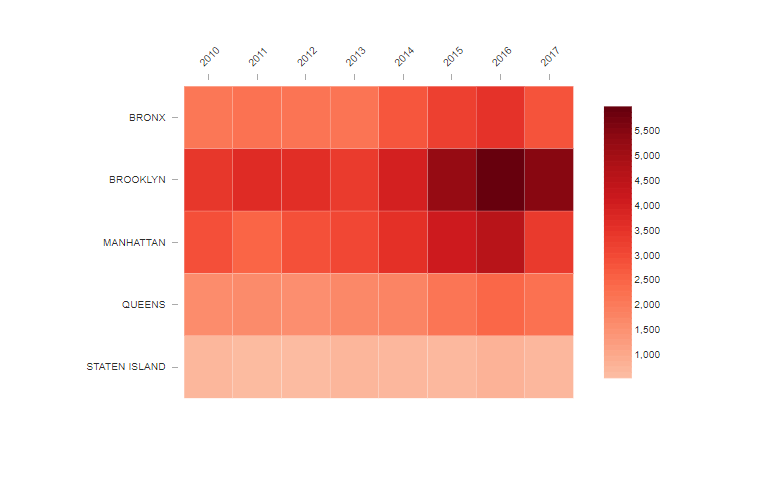  


After this heatmap, we will develop a threshold to select certain averages and keep the top n features.

With these top n features, we will develop a new model and measure the RMSE based on only keeping the most important features. 

Note: below I am normalizing Overall independently, so it is a measure of persistence, not peak importance


In [ ]:
df_save["Overall"] = df_save.mean(axis=1)
# normalize overall on the max 
df_save["Overall"] = df_save["Overall"] / df_save["Overall"].max()

,2017,2018,2019,2020,2021,2022,2023,2024,Overall
A00,0.000000,0.000000,0.000000,0.000000,0.081928,0.000025,0.000000,0.017111,0.134834
A01,0.000000,0.000000,0.104363,0.000000,0.000000,0.008452,0.000000,0.000000,0.138127
A02,1.000000,0.000000,0.313165,0.837628,0.000876,0.096119,0.000000,0.596410,0.792211
A03,0.072184,0.275355,0.295005,0.306179,0.000000,1.000000,0.000000,0.702514,0.746003
A04,0.026346,0.377664,0.000000,0.060244,0.026417,0.362356,0.505969,0.025720,0.442709
...,...,...,...,...,...,...,...,...,...
A59,0.000000,0.004137,0.000000,0.071120,0.000000,0.116342,0.000000,0.000000,0.156993
A60,0.331957,0.004215,0.035422,0.564679,0.010268,0.308099,0.000000,0.000000,0.411560
A61,0.000000,0.000000,0.000000,0.120102,0.000000,0.016140,0.001720,0.000000,0.144149
A62,0.000000,0.005720,0.049942,0.000000,0.010437,0.071951,0.000000,0.000000,0.144170


In [ ]:
# df_save.to_csv("embeddings_importance_2017_to_2024.csv")

In [2]:
df_save = pd.read_csv("embeddings_importance_2017_to_2024.csv").reset_index(drop=True).set_index("Feature")
df_save

,2017,2018,2019,2020,2021,2022,2023,2024,Overall
Feature,,,,,,,,,
A00,0.000000,0.000000,0.000000,0.000000,0.081928,0.000025,0.000000,0.017111,0.134834
A01,0.000000,0.000000,0.104363,0.000000,0.000000,0.008452,0.000000,0.000000,0.138127
A02,1.000000,0.000000,0.313165,0.837628,0.000876,0.096119,0.000000,0.596410,0.792211
A03,0.072184,0.275355,0.295005,0.306179,0.000000,1.000000,0.000000,0.702514,0.746003
A04,0.026346,0.377664,0.000000,0.060244,0.026417,0.362356,0.505969,0.025720,0.442709
...,...,...,...,...,...,...,...,...,...
A59,0.000000,0.004137,0.000000,0.071120,0.000000,0.116342,0.000000,0.000000,0.156993
A60,0.331957,0.004215,0.035422,0.564679,0.010268,0.308099,0.000000,0.000000,0.411560
A61,0.000000,0.000000,0.000000,0.120102,0.000000,0.016140,0.001720,0.000000,0.144149


In [3]:
# split into two subplots
# i will split my df_save horizontally, using iloc (index based split)
# df.iloc[start_row:end_row, start_col:end_col]
half = len(df_save) // 2
df_1 = df_save.iloc[:half,:]
df_2 = df_save.iloc[half:,:]

# print(df_1)
# print(df_2)
# print(len(df_save) // 2)

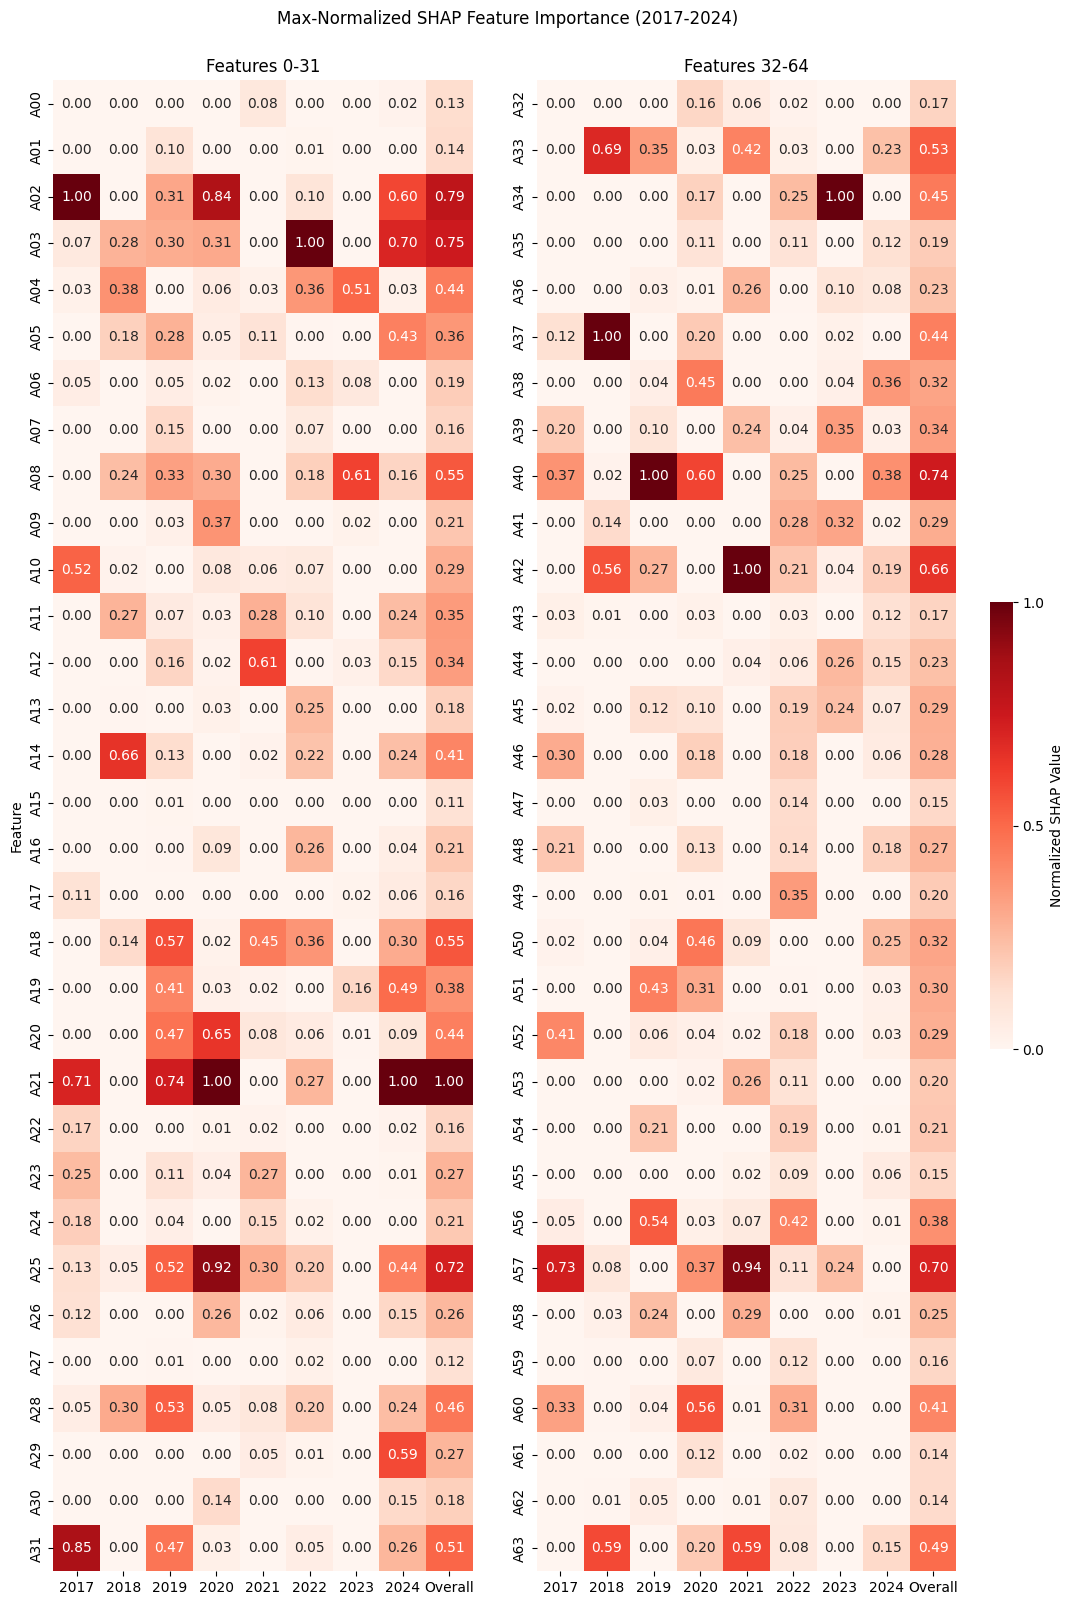

In [14]:
# this is the heatmap, along with the added column at the end. 

plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(1, 2, figsize=(12, 16), gridspec_kw={'width_ratios': [1, 1]})

plt.subplots_adjust(wspace=-0.4, hspace=0)

sns.heatmap(df_1, ax=axes[0], cmap="Reds", annot=True, fmt=".2f", square=True, cbar=False).set_title("Features 0-31")
sns.heatmap(df_2, ax=axes[1], cmap="Reds",
            annot=True, fmt=".2f", square=True, #reduce legend size a bit
            cbar_kws={"shrink": 0.3, "aspect": 20}).set_title("Features 32-64")
axes[1].set_ylabel(None)

axes[0].tick_params(axis="x",labelsize=10, rotation=0)
axes[1].tick_params(axis="x",labelsize=10, rotation=0) 

cbar = axes[1].collections[0].colorbar
cbar.set_ticks([0,0.5,1])
cbar.set_label("Normalized SHAP Value")

fig.suptitle("Max-Normalized SHAP Feature Importance (2017-2024)", y=1)
plt.tight_layout()
# plt.show()

plt.savefig("Max-Normalized SHAP Feature Importance (2017-2024)")

# smaller legend, and add label "Mean Normalized SHAP Value" to legend 
# one png with the two subplots 


Final graph: 

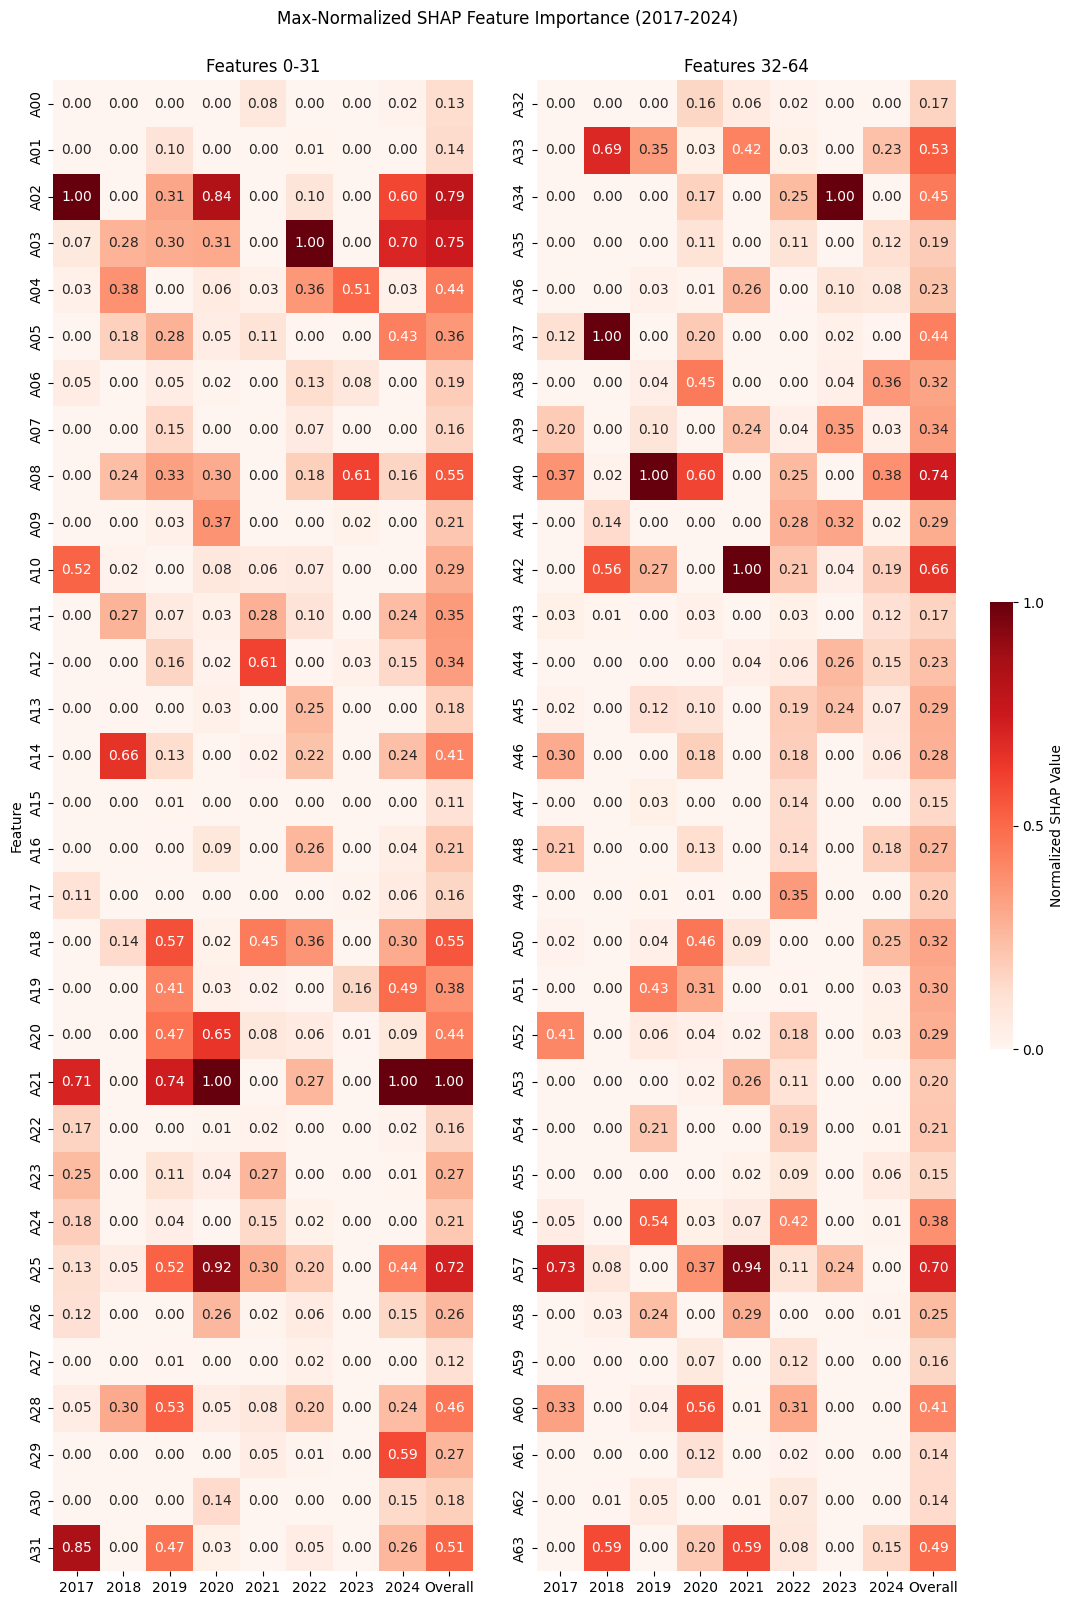

#### Optimal Threshold for Feature Selection

Using the results from the feature selection, I will use the Feature and Overall columns to select the top k parameters. To determine which are the top k parameters I will use the elbow method.

In [7]:
df_save = pd.read_csv("embeddings_importance_2017_to_2024.csv").reset_index(drop=True)
df_elbow = df_save[["Feature","Overall"]]
df_elbow

,Feature,Overall
0,A00,0.134834
1,A01,0.138127
2,A02,0.792211
3,A03,0.746003
4,A04,0.442709
...,...,...
59,A59,0.156993
60,A60,0.411560
61,A61,0.144149
62,A62,0.144170


In [8]:
# in this case, i have my index as my feature name since A00 is the very first feature.
sorted_features = df_elbow["Overall"].sort_values(ascending=False)
x = range(1, len(sorted_features)+1)
kneedle = KneeLocator(x, sorted_features, curve='convex', direction='decreasing')
k = kneedle.knee
print(f"k = {k}")

df_sorted = df_elbow.sort_values("Overall", ascending=False)
top_features = df_sorted["Feature"].iloc[:k].tolist()
print(top_features)
df_elbow.sort_values(by="Overall",ascending=False).nlargest(columns="Overall",n=13)

k = 13
['A21', 'A02', 'A03', 'A40', 'A25', 'A57', 'A42', 'A18', 'A08', 'A33', 'A31', 'A63', 'A28']


,Feature,Overall
21,A21,1.000000
2,A02,0.792211
3,A03,0.746003
40,A40,0.739497
25,A25,0.721899
57,A57,0.704240
42,A42,0.655920
18,A18,0.552161
8,A08,0.547621
33,A33,0.533993


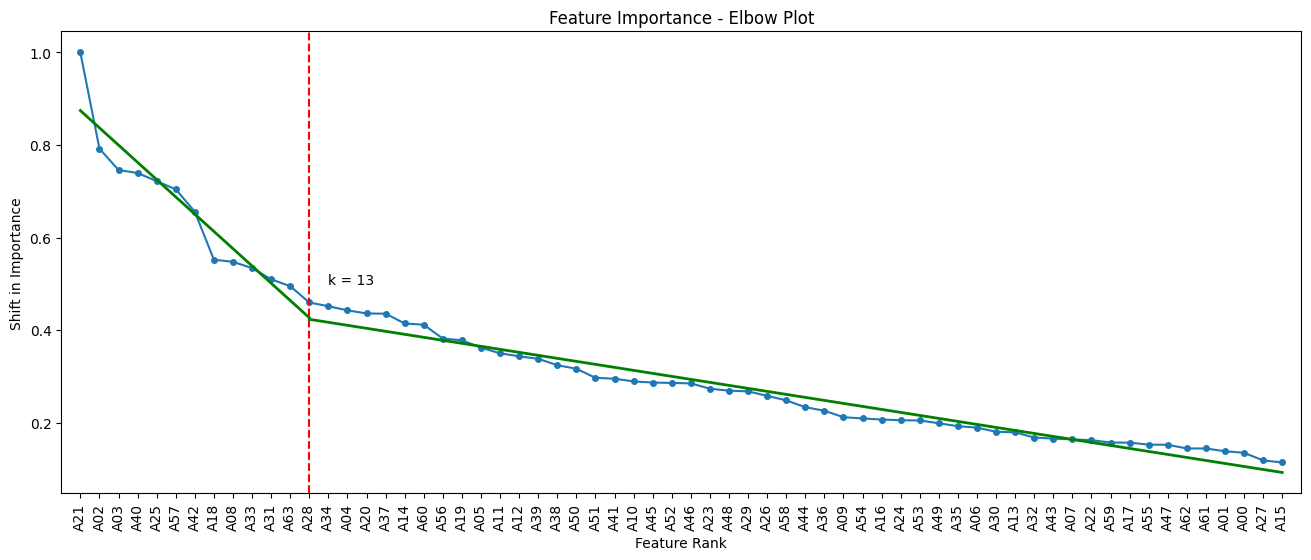

In [9]:
vals = df_elbow["Overall"].sort_values(ascending=False).values
features = df_sorted["Feature"].tolist()

plt.figure(figsize=(16,6))
plt.plot(range(1, len(vals)+1), vals, marker='o',markersize=4)
plt.xticks(range(1, len(vals)+1), features, rotation=90)

plt.axvline(x=13,linestyle="--",color="red") 

plt.text(14, vals[0]*0.5, "k = 13", rotation=0)
plt.xlim(0, len(vals)+1)

plt.xlabel("Feature Rank")
plt.ylabel("Shift in Importance")
plt.title("Feature Importance - Elbow Plot")

# adding two regression lines: 1 to 13 and 13 to 64
# this wil help with interpretability
# array range for slope range
x = np.arange(1, len(vals)+1) 
x_1 = x[:13]
y_1 = vals[:13]
coef1 = np.polyfit(x_1, y_1, 1)
line1 = np.poly1d(coef1)
plt.plot(x_1, line1(x_1), color="green", linewidth=2)

x_2 = x[12:]
y_2 = vals[12:]
coef2 = np.polyfit(x_2, y_2, 1)
line2 = np.poly1d(coef2)
plt.plot(x_2, line2(x_2), color="green", linewidth=2)

plt.show()

In [ ]:
# moving on with the TabNet Regression Model for predicting the actual normalized values for each year.
print(f"Number of features in the final model: {len(top_features)}")
print(top_features)

Number of features in the final model: 13
['A21', 'A02', 'A03', 'A40', 'A25', 'A57', 'A42', 'A18', 'A08', 'A33', 'A31', 'A63', 'A28']


#### Bayesian Hyperparameter Tuning for TabNet Regressor

https://www.kaggle.com/code/liamhealy/bayesian-hyperparameter-tuning-in-python

Our objective function is RMSE (minimize RMSE).

In [11]:
col = df_2017.iloc[:,-1]
col

0      1.513844
1      0.000000
2      0.000000
3      1.868705
4      0.000000
         ...   
97     0.000000
98     0.144827
99     0.000000
100    1.053811
101    0.000000
Name: Cases_2017_normalized, Length: 102, dtype: float64

8 iterations to be performed (backwards loocv):     
read this as [train] -> [target] 
1. [2017,2018,2019,2020,2021,2022,2023] -> [2024]
3. [2017,2018,2019,2020,2021,2022,2024] -> [2023]       
...     
8. [2018,2019,2020,2021,2022,2023,2024] -> [2017]

In [13]:
# I am doing a quick check here to veryify all county col orderings are the same
# this is so I can keep an identifier when training and testing data, if it is ever needed for debugging. 
# counties_is_same_test = []
# for df in dfs:
# 	counties_is_same_test.append(df["County"])

# reference_series = counties_is_same_test[0]
# all_same = True

# for s in counties_is_same_test[1:]:
# 	if not reference_series.equals(s):
# 		all_same = False
# 		break

# print(all_same)
# county_names = df_2017["County"].copy()

# i removed this from loop 
# i want to actaully keep a clean features matrix
# 	it is very important that this remains constant (on the left)
# 	i never shift rows around, so this should work here
# 	df.insert(0, "County", county_names)

In [99]:
warnings.filterwarnings('ignore')
# Set Optuna logging level to WARNING (suppresses INFO messages)
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger('pytorch_tabnet').setLevel(logging.ERROR)

In [ ]:
def create_objective(X_train, X_test, y_train, y_test):
	def objective(trial):
		params = {
			'n_d': trial.suggest_int('n_d', 8, 64),
			'n_a': trial.suggest_int('n_a', 8, 64),
			'n_steps': trial.suggest_int('n_steps', 3, 10),
			'gamma': trial.suggest_float('gamma', 1.0, 2.0),
			'n_independent': trial.suggest_int('n_independent', 1, 5),
			'n_shared': trial.suggest_int('n_shared', 1, 5),
			'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-6, 1e-3, log=True),
			'momentum': trial.suggest_float('momentum', 0.01, 0.4),
			'clip_value': trial.suggest_float('clip_value', 0.5, 2.0),
			'optimizer_params': {'lr': trial.suggest_float('lr', 1e-4, 1e-1, log=True)},
			'scheduler_params': {
				'step_size': trial.suggest_int('step_size', 10, 50),
				'gamma': trial.suggest_float('scheduler_gamma', 0.5, 0.99)
			},
			'scheduler_fn': torch.optim.lr_scheduler.StepLR,
			'mask_type': 'sparsemax'
		}

		model = TabNetRegressor(
			n_d=params['n_d'],
			n_a=params['n_a'],
			n_steps=params['n_steps'],
			gamma=params['gamma'],
			n_independent=params['n_independent'],
			n_shared=params['n_shared'],
			lambda_sparse=params['lambda_sparse'],
			momentum=params['momentum'],
			clip_value=params['clip_value'],
			optimizer_fn=torch.optim.Adam,
			optimizer_params=params['optimizer_params'],
			scheduler_params=params['scheduler_params'],
			scheduler_fn=torch.optim.lr_scheduler.StepLR,
			mask_type=params['mask_type'],
			seed=25,
			verbose=0
		)

		# training and testing data is always diff for each iteration
		# there will be 8 iterations total. 
		model.fit(
			X_train = X_train,
			y_train = y_train,
			eval_set = [(X_test, y_test)],
			eval_metric=["rmse"],
			max_epochs = 100,
			patience = 20,
			batch_size = 256,
			virtual_batch_size = 128
		)

		y_pred = model.predict(X_test)
		rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))

		return rmse
	return objective

In [125]:
def optimization_current_dataset(X_train, X_test, 
																 y_train, y_test, 
																 n_trials=50, 
																 study_name="tabnet_study"):
	'''
	This will be used for when I change my train/test data each iteration.
	I will append the dict result to the ``results`` list in the next cell.  
	'''
	# storing the current iteration reults.

	objective = create_objective(X_train, X_test, y_train, y_test)

	study = optuna.create_study(
		direction='minimize',
		# BO algorithm -> Tree-structured Parzen Estimator
		sampler=TPESampler(seed=25),
		study_name=study_name
  )

	# this is where the optimization takes place.
	study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

	best_params = study.best_params

	final_model = TabNetRegressor(
		n_d=best_params['n_d'],
		n_a=best_params['n_a'],
		n_steps=best_params['n_steps'],
		gamma=best_params['gamma'],
		n_independent=best_params['n_independent'],
		n_shared=best_params['n_shared'],
		lambda_sparse=best_params['lambda_sparse'],
		momentum=best_params['momentum'],
		clip_value=best_params['clip_value'],
		optimizer_params={'lr': best_params['lr']},
		scheduler_params={
				'step_size': best_params['step_size'],
				'gamma': best_params['scheduler_gamma']
		},
		scheduler_fn=torch.optim.lr_scheduler.StepLR,
		mask_type='entmax',
		seed=25,
		verbose=0
	)
    
	final_model.fit(
		X_train=X_train,
		y_train=y_train,
		eval_set=[(X_test, y_test)],
		eval_metric=['rmse'],
		max_epochs=200,
		patience=30,
		batch_size=256,
		virtual_batch_size=128
	)

	dict = {
		'best_params': best_params,
    'best_rmse': study.best_value,
		'model': final_model,
		'study': study
	}
	
	return dict

In [126]:
# years = np.arange(2017, 2025)

# for test_idx in range(len(dfs) - 1, -1, -1):
# 	test_year = years[test_idx]
# 	train_years = np.delete(years, test_idx)
# 	print(f"testing: {test_year}")
# 	print(f"training: {train_years}")

In [137]:
# fixing shape issue
# keep consistent target col across dfs
clean_dfs = []

idx = 0
year = 2017
for df in dfs:
	df_year = dfs[idx]

	# -- SET TARGET COLUMN --
	df_year["target"] = df_year[f"Cases_{year}_normalized"]
	df_year = df_year.drop(columns=[f"Cases_{year}_normalized"])

	clean_dfs.append(df_year)

	idx += 1
	year += 1

In [ ]:
clean_dfs[0]

,County,GEOID,A00,A01,A02,A03,A04,A05,A06,A07,...,A57,A58,A59,A60,A61,A62,A63,Cases_2017,2017_population,target
0,Adams,17001.0,-0.107950,-0.037627,0.036348,-0.096245,0.034700,-0.108684,-0.016728,0.094458,...,0.127413,0.021065,-0.041845,-0.121470,-0.088657,-0.168412,0.027029,1.0,66057,1.513844
1,Alexander,17003.0,-0.094824,-0.056673,-0.040527,-0.063669,-0.016219,-0.048929,0.072583,0.073044,...,0.094908,0.069535,-0.060057,-0.077254,-0.143979,-0.098709,0.065627,0.0,6278,0.000000
2,Bond,17005.0,-0.119659,-0.035458,0.015939,-0.073642,0.008038,-0.100312,0.038363,0.071558,...,0.136704,0.013758,-0.091121,-0.110945,-0.098579,-0.125373,0.048798,0.0,16648,0.000000
3,Boone,17007.0,-0.051854,-0.020323,0.071813,-0.172447,0.046811,-0.092647,-0.024340,0.066154,...,0.077935,0.015019,-0.125815,-0.119691,-0.115291,-0.152706,0.032385,1.0,53513,1.868705
4,Brown,17009.0,-0.112111,-0.012204,0.021089,-0.065725,0.043158,-0.120458,-0.007383,0.122192,...,0.122336,0.021527,-0.024922,-0.125496,-0.108772,-0.168290,0.022709,0.0,6609,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Whiteside,17195.0,-0.072713,-0.077594,0.042785,-0.143906,0.025295,-0.136173,-0.032140,0.108618,...,0.101162,-0.019818,-0.128645,-0.121391,-0.090593,-0.143985,0.063077,0.0,55955,0.000000
98,Will,17197.0,-0.064487,-0.088591,0.062551,-0.139896,0.039499,-0.078033,-0.042707,0.016685,...,0.112932,0.031993,-0.077277,-0.086781,-0.114635,-0.147613,0.005001,1.0,690479,0.144827
99,Williamson,17199.0,-0.140243,-0.058865,-0.017413,0.004954,0.009146,-0.081140,0.018894,0.072165,...,0.150030,0.043505,-0.056262,-0.094795,-0.137470,-0.098129,0.028475,0.0,67049,0.000000
100,Winnebago,17201.0,-0.048765,-0.079403,0.069957,-0.120873,0.062931,-0.106263,-0.041099,0.073488,...,0.103075,0.002925,-0.053409,-0.101476,-0.114592,-0.154284,0.012362,3.0,284681,1.053811


In [141]:
results = []
# dfs_testing = [df_2017, df_2018, df_2019]

years = np.arange(2017, 2025)

# will run from 0 -- 2017 to 7 -- 2024 (0 indexed starts at 2017)
# reversing the index so iteration 1 starts with 
for test_idx in range(len(clean_dfs) - 1, -1, -1):
	# this is storing the top 13 parameters from the feature selection section
	top_features_copy = top_features.copy()

	test_df = clean_dfs[test_idx]

	train_dfs_list = [clean_dfs[i] for i in range(len(clean_dfs)) if i != test_idx]
	train_dfs = pd.concat(train_dfs_list, ignore_index=True)

	test_year = years[test_idx]
	train_years = [years[i] for i in range(len(clean_dfs)) if i != test_idx]

	X_train = train_dfs[top_features_copy].values
	y_train = train_dfs["target"].values.reshape(-1, 1)

	X_test = test_df[top_features_copy].values
	y_test = test_df["target"].values.reshape(-1, 1)

	# =========== above testing is done ===========

	iter_results_dict = optimization_current_dataset(X_train, X_test, y_train, y_test, study_name=f"tabnet_study_target_{test_year}")
	iter_results_dict["training"] = train_years
	iter_results_dict["testing"] = test_year 

	results.append(iter_results_dict)

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 24 with best_epoch = 4 and best_val_0_rmse = 0.38483

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 0.38605

Early stopping occurred at epoch 23 with best_epoch = 3 and best_val_0_rmse = 0.37777

Early stopping occurred at epoch 64 with best_epoch = 44 and best_val_0_rmse = 0.3821

Early stopping occurred at epoch 34 with best_epoch = 14 and best_val_0_rmse = 0.38167

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 0.43663

Early stopping occurred at epoch 33 with best_epoch = 13 and best_val_0_rmse = 0.38421

Early stopping occurred at epoch 22 with best_epoch = 2 and best_val_0_rmse = 0.38571

Early stopping occurred at epoch 50 with best_epoch = 30 and best_val_0_rmse = 0.38297

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 0.85686

Early stopping occurred at epoch 53 with best_epoch = 33 and best_val_0_rmse = 0.37817

Early stopping occurred at epoch 32 wi

KeyboardInterrupt: 

In [135]:
print("X_train:", X_train.shape, "y_train:", y_train.shape)


X_train: (714, 13) y_train: (714, 1)


In [131]:
# save models and everything as pickle file 
with open('tabnet_results.pkl', 'wb') as f:
	pickle.dump(results, f)

In [132]:
# to load results later
with open('tabnet_results.pkl', 'rb') as f:
	results = pickle.load(f)

In [133]:
results

[{'best_params': {'n_d': 18,
   'n_a': 40,
   'n_steps': 6,
   'gamma': 1.6428977948018126,
   'n_independent': 3,
   'n_shared': 2,
   'lambda_sparse': 0.00046025350733881596,
   'momentum': 0.10644221551333238,
   'clip_value': 1.3518965684654145,
   'lr': 0.03352559821062671,
   'step_size': 36,
   'scheduler_gamma': 0.8206629350891707},
  'best_rmse': 1.4513641020125456,
  'model': TabNetRegressor(n_d=18, n_a=40, n_steps=6, gamma=1.6428977948018126, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=3, n_shared=2, epsilon=1e-15, momentum=0.10644221551333238, lambda_sparse=0.00046025350733881596, seed=25, clip_value=1.3518965684654145, verbose=0, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.03352559821062671}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 36, 'gamma': 0.8206629350891707}, mask_type='entmax', input_dim=13, output_dim=1, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=

In [129]:
print("Fold:", test_year)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Train NaN summary:\n", pd.DataFrame(X_train, columns=top_features_copy).isna().sum())


Fold: 2024
X_train shape: (714, 13)
X_test shape: (102, 13)
Train NaN summary:
 A21    0
A02    0
A03    0
A40    0
A25    0
A57    0
A42    0
A18    0
A08    0
A33    0
A31    0
A63    0
A28    0
dtype: int64
